# Assignment 4

## Prerequisite

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

### Data download 

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


### Create a test set

In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
print('Number of validation batches: %d' % val_batches)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 32
Number of test batches: 6


### Configure the dataset for performance

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

### Rescale the pixel values

In [7]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Create the base modle from pre-trained convents 

In [8]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,  
                                            weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


### Feature extraction

In [9]:
base_model.trainable = False

### Add a classification head

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2048)
(32, 1)


In [11]:
inputs = tf.keras.Input(shape=(224, 224, 3)) 
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      2,049 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Compile the model

In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

## Train the model

In [13]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.4191 - loss: 0.8854
initial loss: 0.89
initial accuracy: 0.42
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 272s 4s/step - accuracy: 0.5592 - loss: 0.8126 - val_accuracy: 0.7364 - val_loss: 0.5478
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 274s 4s/step - accuracy: 0.7372 - loss: 0.5319 - val_accuracy: 0.8899 - val_loss: 0.3402
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.8421 - loss: 0.3778 - val_accuracy: 0.9332 - val_loss: 0.2469
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 313s 5s/step - accuracy: 0.8968 - loss: 0.2975 - val_accuracy: 0.9691 - val_loss: 0.1805
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 277s 4s/step - accuracy: 0.9253 - loss: 0.2414 - val_accuracy: 0.9703 - val_loss: 0.1509
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - accuracy: 0.9311 - loss: 0.1987 - val_accuracy: 0.9765 - val_loss: 0.1252
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.9436 - loss: 0.1804 - val_accuracy: 0.9851 - val_loss: 0.1

### Learning curves

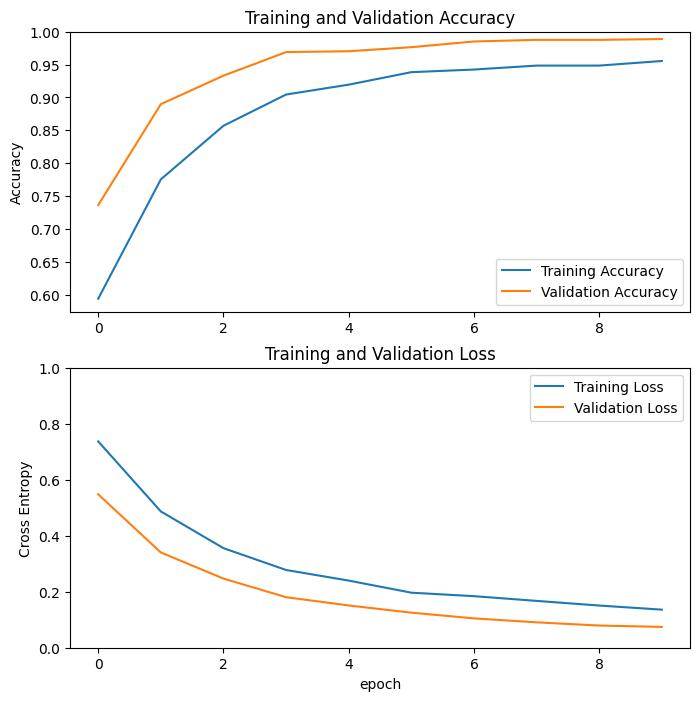

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

In [15]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


### Compile and continue training the model

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

model.summary()
len(model.trainable_variables)

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      2,049 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 19,454,977 (74.21 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 355s 5s/step - accuracy: 0.9364 - loss: 0.1900 - val_accuracy: 0.9889 - val_loss: 0.0380
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 373s 6s/step - accuracy: 0.9578 - loss: 0.1138 - val_accuracy: 0.9926 - val_loss: 0.0233
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 507s 8s/step - accuracy: 0.9733 - loss: 0.0812 - val_accuracy: 0.9889 - val_loss: 0.0280
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 622s 10s/step - accuracy: 0.9799 - loss: 0.0631 - val_accuracy: 0.9901 - val_loss: 0.0217
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 401s 6s/step - accuracy: 0.9787 - loss: 0.0656 - val_accuracy: 0.9913 - val_loss: 0.0229
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 428s 7s/step - accuracy: 0.9838 - loss: 0.0479 - val_accuracy: 0.9901 - val_loss: 0.0219
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 552s 9s/step - accuracy: 0.9914 - loss: 0.0338 - val_accuracy: 0.9926 - val_loss: 0.0181
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 542s 9s/step - accuracy: 0.9900 - loss: 0.0346 - val_accuracy: 0

### Learning curves

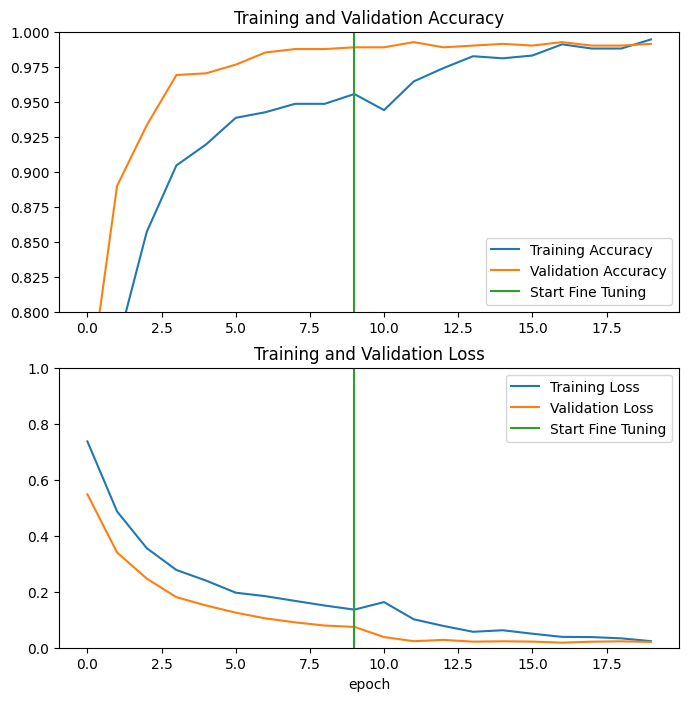

In [17]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and prediction 

In [20]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

# class_names = train_dataset.class_names

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(class_names[predictions[i]])
#   plt.axis("off")

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9950 - loss: 0.0192
Test accuracy : 0.9947916865348816
Predictions:
 [1 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1]
Labels:
 [1 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1]
